# Phase 4 Project - Sentiment Analysis of Depression in Tweets

![depression_tweeting](images/depression_tweeting.png)

**Name**:  Jordana Tepper  
**Pace**:  Full Time  
**Instructor**: Joseph Mata  

## Overview

## Business Understanding

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt

# NLTK Imports
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.collocations import *

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
# from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.base import BaseEstimator, TransformerMixin 

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

In [2]:
# Loading in dataset
df = pd.read_csv('data/sentiment_tweets3.csv')

In [3]:
# Previewing dataset
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [4]:
# Looking at missing values
df.isna().sum()

Index                        0
message to examine           0
label (depression result)    0
dtype: int64

There are no missing values.

In [5]:
# Looking at distribution of target
df['label (depression result)'].value_counts(normalize = True)

0    0.775645
1    0.224355
Name: label (depression result), dtype: float64

The dataset is imbalanced, so I will use SMOTE to fix this.

## Data Preparation

In [6]:
# Dropping last row because the entry is empty
df = df.drop(10313)

In [7]:
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10308,802308,Many sufferers of depression aren't sad; they ...,1
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [8]:
# Dropping index column
df = df.drop(columns = ['Index'], axis = 1)

In [9]:
df

,message to examine,label (depression result)
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10308,Many sufferers of depression aren't sad; they ...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [10]:
# Renaming columns
df = df.rename(columns = {'message to examine':'tweet', 'label (depression result)': 'depression'})

In [11]:
df

,tweet,depression
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10308,Many sufferers of depression aren't sad; they ...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


## Modeling

**Due to the fact that the goal of my model is to aid Twitter in targeting those who appear depressed based on their tweets with advertisements about therapy and support, a false negative is more costly than a false positive.**

**Therefore, the metric that matters most in our project is recall.**

In [12]:
# Train test split
X = df['tweet']
y = df['depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Creating a Stemming and Tokenizing Function

In [13]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")
stopwords_list = stopwords.words('english')


from nltk.tokenize import RegexpTokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [14]:
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [15]:
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

### Visualizing Word Frequency

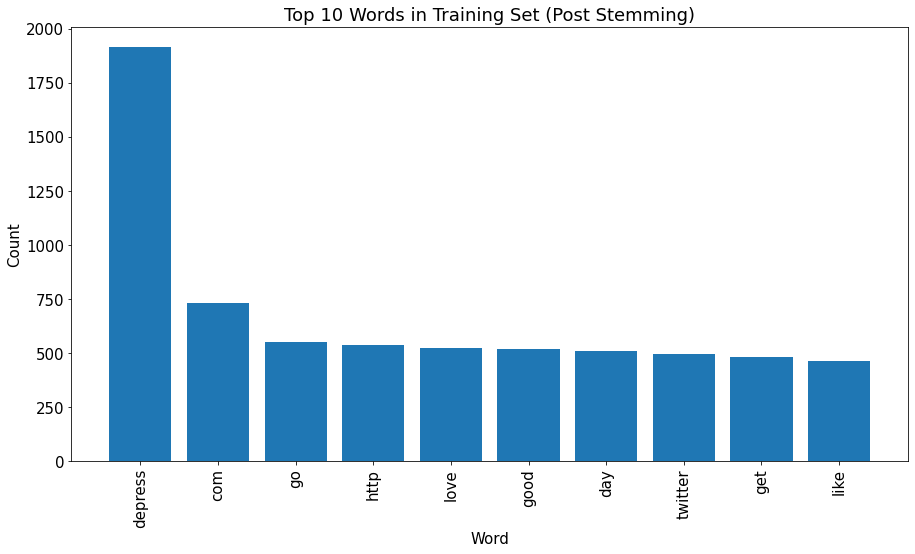

In [16]:
X_train_viz = X_train.apply(stem_and_tokenize)

def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stemmed_stopwords]
    return stopwords_removed

X_train_viz = X_train_viz.apply(remove_stopwords)
freq_dist = FreqDist(X_train_viz.explode())


top_10 = list(zip(*freq_dist.most_common(10)))
tokens = top_10[0]
counts = top_10[1]

fig, ax = plt.subplots(figsize = (15,8))
ax.bar(tokens, counts)

plt.title("Top 10 Words in Training Set (Post Stemming)", fontdict = {'fontsize': 18})
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Word", fontsize = 15)
ax.tick_params(axis="x", rotation=90, labelsize = 15)
ax.tick_params(axis="y", rotation=0, labelsize = 15)
plt.show()

In [17]:
word_list = list(X_train_viz.explode().values)

In [18]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [19]:
finder = BigramCollocationFinder.from_words(word_list)

In [20]:
finder.apply_freq_filter(10)
finder.nbest(bigram_measures.likelihood_ratio, 20)

[('twitter', 'com'),
 ('pic', 'twitter'),
 ('bit', 'ly'),
 ('https', 'www'),
 ('http', 'twitpic'),
 ('http', 'bit'),
 ('twitpic', 'com'),
 ('mental', 'health'),
 ('https', 'twitter'),
 ('ift', 'tt'),
 ('depress', 'anxieti'),
 ('2018', '04'),
 ('emot', 'intellectu'),
 ('intellectu', 'develop'),
 ('blip', 'fm'),
 ('anxieti', 'depress'),
 ('tie', 'kid'),
 ('good', 'morn'),
 ('look', 'forward'),
 ('kid', 'emot')]

In [21]:
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:20]

[(('twitter', 'com'), 0.0042927340989399295),
 (('pic', 'twitter'), 0.002871024734982332),
 (('depress', 'anxieti'), 0.0018357994699646643),
 (('anxieti', 'depress'), 0.001573542402826855),
 (('https', 'www'), 0.0014631183745583039),
 (('bit', 'ly'), 0.001449315371024735),
 (('http', 'bit'), 0.0013941033568904593),
 (('https', 'twitter'), 0.001325088339222615),
 (('http', 'twitpic'), 0.0012698763250883391),
 (('twitpic', 'com'), 0.0012698763250883391),
 (('depress', 'https'), 0.0009524072438162545),
 (('good', 'morn'), 0.0008281802120141343),
 (('mental', 'health'), 0.0007591651943462897),
 (('http', 'www'), 0.000717756183745583),
 (('last', 'night'), 0.000579726148409894),
 (('cure', 'depress'), 0.0005521201413427562),
 (('feel', 'like'), 0.0005107111307420495),
 (('great', 'depress'), 0.0004831051236749117),
 (('depress', 'http'), 0.00046930212014134273),
 (('2018', '04'), 0.00045549911660777384)]

After seeing the frequency of terms that do not seem to provide much context to a tweet such as, "http", "https", "com", and "www", I decided that I will make an additional stop words list that includes these terms to see if their removal strengthens or weakens the model.

In [22]:
stemmed_stopwords_amended = stemmed_stopwords.copy()

In [23]:
stemmed_stopwords_amended += ['http', 'https', 'com', 'www', 'ly'] 

### Model 1a: Count Vectorizer and Random Forest (Basic Stemmed Stop Words)

In [24]:
pipe_rfc_vec_a = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [25]:
pipe_rfc_vec_a.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [26]:
y_preds_rfc_vec_a = pipe_rfc_vec_a.predict(X_test)

In [27]:
recall_score(y_test, y_preds_rfc_vec_a)

0.9730639730639731

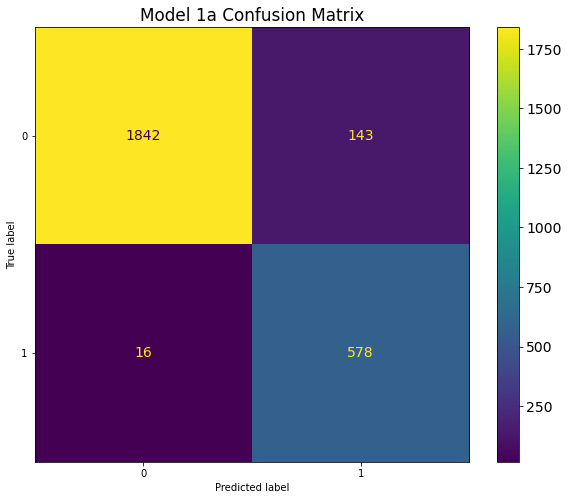

In [28]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 1a Confusion Matrix')
plot_confusion_matrix(pipe_rfc_vec_a, X_test, y_test, ax=ax);

In [29]:
# pipe_rfc_vec.score(X_test, y_test)

In [30]:
# Instantiate the vectorizer
# countvectorizer = CountVectorizer(
#                                   stop_words=stemmed_stopwords, 
#                                   tokenizer=stem_and_tokenize)

In [31]:
# Fit the vectorizer on X_train and transform it
# X_train_count_vec = countvectorizer.fit_transform(X_train)

In [32]:
# Visually inspect the vectorized train data
# pd.DataFrame.sparse.from_spmatrix(X_train_count_vec, columns=countvectorizer.get_feature_names())

In [33]:
# X_test_count_vec = countvectorizer.transform(X_test)

In [34]:
# # Visually inspect the vectorized test data
# pd.DataFrame.sparse.from_spmatrix(X_test_count_vec, columns=countvectorizer.get_feature_names())

In [35]:
# # Instantiate and fit a Random Forest model
# rfc = RandomForestClassifier(random_state = 42)
# rfc.fit(X_train_count_vec, y_train)

In [36]:
# y_preds_rfc = rfc.predict(X_test_count_vec)

In [37]:
# recall_score(y_test, y_preds_rfc)

In [38]:
# rfc.score(X_test_count_vec, y_test)

### Model 1b: Count Vectorizer and Random Forest (Amended Stemmed Stop Words)

In [39]:
pipe_rfc_vec_b = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [40]:
pipe_rfc_vec_b.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [41]:
y_preds_rfc_vec_b = pipe_rfc_vec_b.predict(X_test)

In [42]:
recall_score(y_test, y_preds_rfc_vec_b)

0.9713804713804713

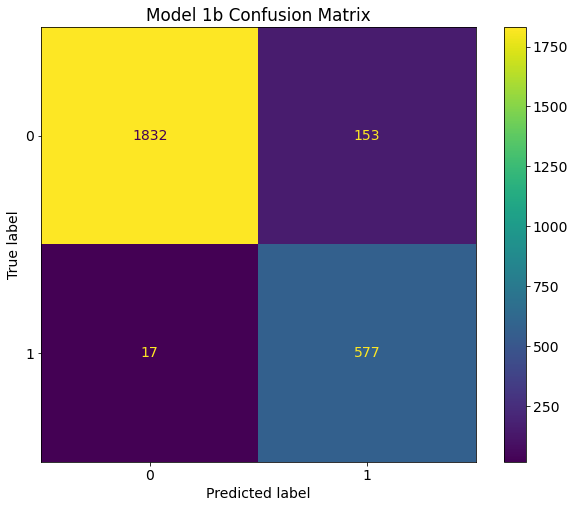

In [43]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 1b Confusion Matrix')
plot_confusion_matrix(pipe_rfc_vec_b, X_test, y_test, ax=ax);

### Model 2a: TF-IDF Vectorizer and Random Forest (Basic Stemmed Stop Words)

In [44]:
pipe_rfc_tfidf_a = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [45]:
pipe_rfc_tfidf_a.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [46]:
y_preds_rfc_tfidf_a = pipe_rfc_tfidf_a.predict(X_test)

In [47]:
recall_score(y_test, y_preds_rfc_tfidf_a)

0.9865319865319865

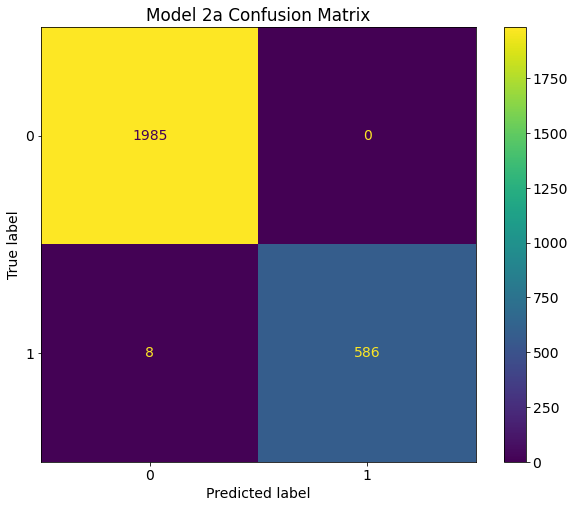

In [48]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 2a Confusion Matrix')
plot_confusion_matrix(pipe_rfc_tfidf_a, X_test, y_test, ax=ax);

In [49]:
# pipe_rfc_tfidf.score(X_test, y_test)

In [50]:
# # Instantiate the vectorizer
# tfidf = TfidfVectorizer(
#     stop_words=stemmed_stopwords,
#     tokenizer=stem_and_tokenize
# )

In [51]:
# # Fit the vectorizer on X_train and transform it
# X_train_tfidf_vec = tfidf.fit_transform(X_train)

In [52]:
# # Visually inspect the vectorized train data
# pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_vec, columns=tfidf.get_feature_names())

In [53]:
# # Transform the test data
# X_test_tfidf_vec = tfidf.transform(X_test)

In [54]:
# # Visually inspect the vectorized test data
# pd.DataFrame.sparse.from_spmatrix(X_test_tfidf_vec, columns=tfidf.get_feature_names())

In [55]:
# # NOT NEEDED
# from sklearn.model_selection import cross_val_score
# from sklearn.naive_bayes import MultinomialNB


# # Instantiate a MultinomialNB classifier
# baseline_model = MultinomialNB()
# stemmed_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
# stemmed_cv

In [56]:
# # Instantiate and fit a Random Forest model
# rfc_2 = RandomForestClassifier(random_state = 42)
# rfc_2.fit(X_train_tfidf_vec, y_train)

In [57]:
# y_preds_rfc2 = rfc_2.predict(X_test_tfidf_vec)

In [58]:
# recall_score(y_test, y_preds_rfc2)

In [59]:
# rfc_2.score(X_test_tfidf_vec, y_test)

### Model 2b: TF-IDF Vectorizer and Random Forest (Amended Stemmed Stop Words)

In [60]:
pipe_rfc_tfidf_b = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [61]:
pipe_rfc_tfidf_b.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [62]:
y_preds_rfc_tfidf_b = pipe_rfc_tfidf_b.predict(X_test)

In [63]:
recall_score(y_test, y_preds_rfc_tfidf_b)

0.9848484848484849

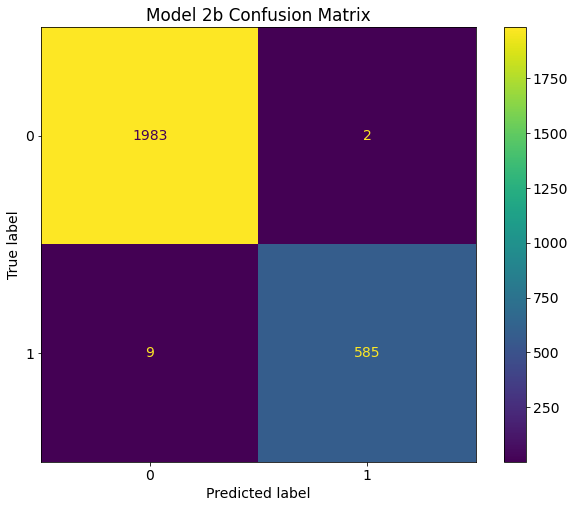

In [64]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 2b Confusion Matrix')
plot_confusion_matrix(pipe_rfc_tfidf_b, X_test, y_test, ax=ax);

### Model 3a: Count Vectorizer and Multinomial Naive Bayes (Basic Stemmed Stop Words)

In [65]:
pipe_mnb_vec_a = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [66]:
pipe_mnb_vec_a.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [67]:
y_preds_mnb_vec_a = pipe_mnb_vec_a.predict(X_test)

In [68]:
recall_score(y_test, y_preds_mnb_vec_a)

0.98989898989899

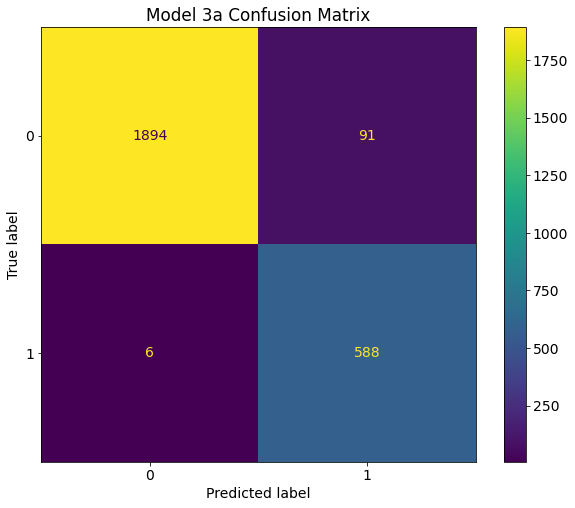

In [69]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 3a Confusion Matrix')
plot_confusion_matrix(pipe_mnb_vec_a, X_test, y_test, ax=ax);

In [70]:
# pipe_mnb_vec.score(X_test, y_test)

### Model 3b: Count Vectorizer and Multinomial Naive Bayes (Amended Stemmed Stop Words)

In [71]:
pipe_mnb_vec_b = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [72]:
pipe_mnb_vec_b.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [73]:
y_preds_mnb_vec_b = pipe_mnb_vec_b.predict(X_test)

In [74]:
recall_score(y_test, y_preds_mnb_vec_b)

0.9865319865319865

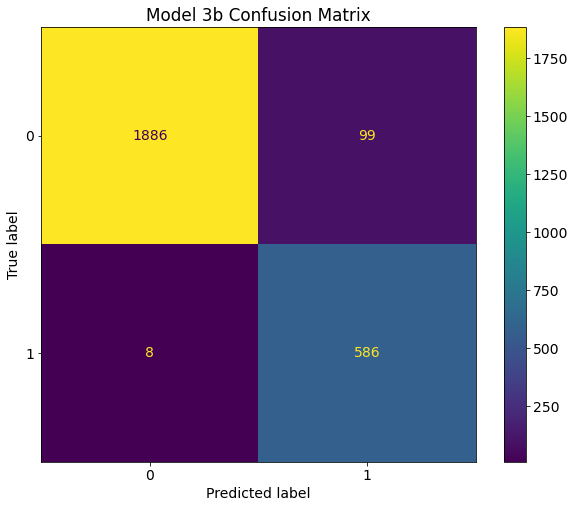

In [75]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 3b Confusion Matrix')
plot_confusion_matrix(pipe_mnb_vec_b, X_test, y_test, ax=ax);

### Model 4a: TF-IDF and Multinomial Naive Bayes (Basic Stemmed Stop Words)

In [76]:
pipe_mnb_tfidc_a = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [77]:
pipe_mnb_tfidc_a.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [78]:
y_preds_mnb_tfidf_a = pipe_mnb_tfidc_a.predict(X_test)

In [79]:
recall_score(y_test, y_preds_mnb_tfidf_a)

0.9848484848484849

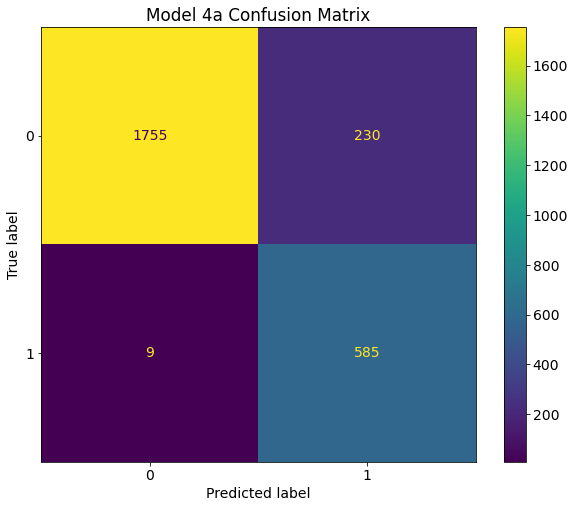

In [80]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 4a Confusion Matrix')
plot_confusion_matrix(pipe_mnb_tfidc_a, X_test, y_test, ax=ax);

In [81]:
# pipe_mnb_tfidc.score(X_test, y_test)

### Model 4b: TF-IDF and Multinomial Naive Bayes (Amended Stemmed Stop Words)

In [82]:
pipe_mnb_tfidc_b = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [83]:
pipe_mnb_tfidc_b.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7fc011117dc0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [84]:
y_preds_mnb_tfidf_b = pipe_mnb_tfidc_b.predict(X_test)

In [85]:
recall_score(y_test, y_preds_mnb_tfidf_b)

0.9831649831649831

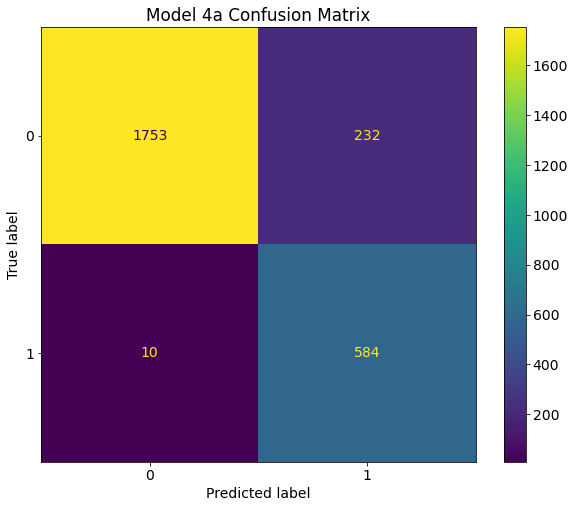

In [86]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 4a Confusion Matrix')
plot_confusion_matrix(pipe_mnb_tfidc_b, X_test, y_test, ax=ax);

## Evaluation

Based on recall scores (and confusion matrices), the two best models are Model 3a and Model 2a. Model 3a has a recall score of 98.99%, and Model 2a has a recall score of 98.65%. Although Model 3b also has a recall score of 98.65%, Model 2a has a better overall confusion matrix (8 false negatives and 0 false positives).

### Comparing Sample Data Using the Two Best Models: Model 2a and Model 3a

In [87]:
sample_1 = ['I am depressed']

In [88]:
print(pipe_rfc_tfidf_a.predict(sample_1))
print(pipe_mnb_vec_a.predict(sample_1))

[1]
[1]


In [89]:
sample_2 = ['I want to die']

In [90]:
print(pipe_rfc_tfidf_a.predict(sample_2)) # Flawed
print(pipe_mnb_vec_a.predict(sample_2))

[0]
[1]


In [91]:
sample_3 = ['Kill me']

In [92]:
print(pipe_rfc_tfidf_a.predict(sample_3)) # Flawed
print(pipe_mnb_vec_a.predict(sample_3))

[0]
[1]


In [93]:
sample_4 = ['I want to kill myself']

In [94]:
print(pipe_rfc_tfidf_a.predict(sample_4)) # Flawed
print(pipe_mnb_vec_a.predict(sample_4)) # Flawed

[0]
[0]


In [95]:
sample_5 = ['i am depressed'] # Testing capitalization

In [96]:
print(pipe_rfc_tfidf_a.predict(sample_5))
print(pipe_mnb_vec_a.predict(sample_5))

[1]
[1]


In [97]:
sample_6 = ['I am not depressed']

In [98]:
print(pipe_rfc_tfidf_a.predict(sample_6)) # Flawed
print(pipe_mnb_vec_a.predict(sample_6)) # Flawed

[1]
[1]


In [99]:
sample_7 = ['I need help']

In [100]:
print(pipe_rfc_tfidf_a.predict(sample_7)) # Flawed
print(pipe_mnb_vec_a.predict(sample_7))

[0]
[1]


In [101]:
sample_8 = ['My dog is so cute']

In [102]:
print(pipe_rfc_tfidf_a.predict(sample_8))
print(pipe_mnb_vec_a.predict(sample_8))

[0]
[0]


In [103]:
sample_9 = ['I need a good new show to watch']

In [104]:
print(pipe_rfc_tfidf_a.predict(sample_9))
print(pipe_mnb_vec_a.predict(sample_9))

[0]
[0]


In [105]:
sample_10 = ['School is so stressful']

In [106]:
print(pipe_rfc_tfidf_a.predict(sample_10)) #Flawed
print(pipe_mnb_vec_a.predict(sample_10))

[0]
[1]


In [107]:
sample_11 = ["I'm so hungry, what should I eat?"]

In [108]:
print(pipe_rfc_tfidf_a.predict(sample_11))
print(pipe_mnb_vec_a.predict(sample_11))

[0]
[0]


In [109]:
sample_12 = ['Procrasinating doing my homework']

In [110]:
print(pipe_rfc_tfidf_a.predict(sample_12))
print(pipe_mnb_vec_a.predict(sample_12))

[0]
[0]


In [111]:
sample_13 = ['I am depro']

In [112]:
print(pipe_rfc_tfidf_a.predict(sample_13)) #Flawed
print(pipe_mnb_vec_a.predict(sample_13)) # Flawd

[0]
[0]


In [113]:
sample_14 = ['I am emo']

In [114]:
print(pipe_rfc_tfidf_a.predict(sample_14)) # Flawed
print(pipe_mnb_vec_a.predict(sample_14)) # Flawed

[0]
[0]


#### Thoughts:

With recall being the primary metric, the best models are Models 2a and 3a. More specifically, Model 2a has a recall of 98.65% (8 false negatives) and Model 3a has a recall of 98.99% (6 false negatives). Despite Model 3a having 2 fewer false negatives, I contemplated making my final model Model 2a rather than Model 3a due to the fact that it has no false positives while Model 3a has 91 false positives. In other words, Model 2a minimizes both false negatives and false positives. Furthermore, there is not much difference in the recall percentages of the two models, and a difference of 2 false negatives does not seem too significant. Nevertheless, after doing some sample tweets, I decided that my final model is Model 3a. While both models were flawed with some of the sample tweets, the specific examples that led me to this decision are "I want to die", "Kill me", and "I need help." If anyone were to see these tweets, they would likely believe that the user is potentially struggling with depression or other mental health concerns, so when Model 2a did not pick up on such patterns, I decided that Model 3a is better. 

## Preparing for Deployment of Model

### Pickling Model 2

In [115]:
import pickle

In [117]:
with open("model2a.pkl", "wb") as f:
    pickle.dump(pipe_rfc_tfidf_a, f)

### Pickling Model 3

In [118]:
with open("model3a.pkl", "wb") as f:
    pickle.dump(pipe_mnb_vec_a, f)

## Conclusions

### Limitations

- The model fails to understand slang words such as 'emo' and 'depro'
- The model also fails to properly interpret negation in statements such as, "I am NOT depressed" or "I am NOT okay"
- These two limitations likely root from the fact that this dataset contains only 10,313 tweets meaning that the model cannot capture every pattern of text that exists online.

### Next Steps

If I had access to more data, I would do the following:

- Acquire a larger dataset
- Acquire more data that accounts for slang words
- Develop models that incorporates other languages